Retrieve the fake positive data and led a statistical study out of it :

    - Comparison of the amount of fake positive depending on the training set
    - Correlation of given objects detected by different training set 
    

# Imports


In [32]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sys,os
from importlib import reload
from matplotlib_venn import venn2, venn3


from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
from venny4py.venny4py import *
from collections import Counter
from matplotlib import pyplot as plt
from upsetplot import generate_counts, plot,from_contents

import pandas as pd
pd.set_option('display.max_columns', None)

from mpl_toolkits.axes_grid1 import make_axes_locatable

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Permet d'enlever les Warning tensorflow

np.random.seed(1) # NumPy
import random
random.seed(2) # Python
tf.random.set_seed(3) # Tensorflow 

sys.path.append('..')
sys.path.append('/sps/lsst/users/rbonnetguerrini/ML4_transientV1')

from utils import ImageDisplayer, datadir, rundir
from CNN_model import CNNHyperModel
from Retrieve_data import retrieve_data
from df_bogus import trans_deg2, df_proba, spy

imagedir = f'{rundir}/Compare_visit/Figure/'
models = f'{rundir}/Compare_visit/models/'

# Retrieve data 

In [33]:
test_size = 0.2
nbre_data = 48093 # Amount of data used in one visit

In [34]:
# Recovery of normalize data and dataframe which contains features
data_90780 = retrieve_data(nbre_visit=90780, nbre_data = nbre_data)
df_train_90780, df_test_90780, x_train_90780, x_test_90780, y_train_90780, y_test_90780 = data_90780.donnees(test_size=test_size)
df_test_90780, x_test_90780, y_test_90780 = spy(df_test_90780, x_test_90780, y_test_90780)
df_proba_90780 = df_proba(test_size, df_test_90780, x_test_90780, y_test_90780, 'model_4_visit')

Taille des données de test : (10680, 30, 30, 1)
Test accuracy : 0.9444
334/334 [==============================] - 1s 2ms/step
potential real transcient 498
Test efficacité : 0.9444


In [35]:
# Recovery of normalize data and dataframe which contains features
data_100764 = retrieve_data(nbre_visit=100764, nbre_data = nbre_data)
df_train_100764, df_test_100764, x_train_100764, x_test_100764, y_train_100764, y_test_100764 = data_100764.donnees(test_size=test_size)
df_test_100764, x_test_100764, y_test_100764 = spy(df_test_100764, x_test_100764, y_test_100764)
df_proba_100764 = df_proba(test_size, df_test_100764, x_test_100764, y_test_100764, 'model_4_visit')

Taille des données de test : (8580, 30, 30, 1)
Test accuracy : 0.9435
269/269 [==============================] - 1s 2ms/step
potential real transcient 356
Test efficacité : 0.9435


In [36]:
# Recovery of normalize data and dataframe which contains features
data_101836 = retrieve_data(nbre_visit=101836, nbre_data = nbre_data)
df_train_101836, df_test_101836, x_train_101836, x_test_101836, y_train_101836, y_test_101836 = data_101836.donnees(test_size=test_size)
df_test_101836, x_test_101836, y_test_101836 = spy(df_test_101836, x_test_101836, y_test_101836)
df_proba_101836 = df_proba(test_size, df_test_101836, x_test_101836, y_test_101836, 'model_4_visit')

Taille des données de test : (16075, 30, 30, 1)
Test accuracy : 0.9594
503/503 [==============================] - 1s 2ms/step
potential real transcient 443
Test efficacité : 0.9594


In [37]:
# Recovery of normalize data and dataframe which contains features
data_89762 = retrieve_data(nbre_visit=89762, nbre_data = nbre_data)
df_train_89762, df_test_89762, x_train_89762, x_test_89762, y_train_89762, y_test_89762 = data_89762.donnees(test_size=test_size)
df_test_89762, x_test_89762, y_test_89762 = spy(df_test_89762, x_test_89762, y_test_89762)
df_proba_89762 = df_proba(test_size, df_test_89762, x_test_89762, y_test_89762, 'model_4_visit')

Taille des données de test : (8356, 30, 30, 1)
Test accuracy : 0.9356
262/262 [==============================] - 1s 2ms/step
potential real transcient 493
Test efficacité : 0.9356


In [38]:
# Recovery of normalize data and dataframe which contains features
data_93404 = retrieve_data(nbre_visit=93404)
df_train_93404, df_test_93404, x_train_93404, x_test_93404, y_train_93404, y_test_93404 = data_93404.donnees(test_size=test_size)
df_test_93404, x_test_93404, y_test_93404 = spy(df_test_93404, x_test_93404, y_test_93404)
df_proba_93404 = df_proba(test_size, df_test_93404, x_test_93404, y_test_93404, 'model_4_visit')

Taille des données de test : (12133, 30, 30, 1)
Test accuracy : 0.9169
380/380 [==============================] - 1s 2ms/step
potential real transcient 797
Test efficacité : 0.9169


# Return potential transient index

In [9]:

def potential_transient(test_size, df_test, x_test, y_test, model, path=None):
    '''
    Produces a table containing the prediction made by the model for each image
    Also calculates the number of errors and the detection efficiency of the model
        
    test_size : Percentage of data that is used
    df_test : dataframe containing the various information associated with the images, in particular the image label
    x_test : matrix containing test data
    y_test : array containing the test labels associated with the test data
    model : model used to make the prediction
    path : path to model
        
    return :
        
    df_test = dataframe containing the information associated with the images as well as the predictions made by the model
        
    '''

    #new label for bogus/transcients
    df_test['bogus_transient']=['bogus'if (a==0) else 'transient' for a in df_test['y_test']]
    print('Taille des données de test :', x_test.shape)
    
    #loading model
    if path is not None:
        load_model = tf.keras.models.load_model(f'{path}/{model}.h5')
        
    else:
        load_model = tf.keras.models.load_model(f'{rundir}models/{model}.h5')
        
    score = load_model.evaluate(x_test, y_test, verbose=0, batch_size=None, steps=None)

    print(f'Test loss     : {score[0]:4.4f}')
    print(f'Test accuracy : {score[1]:4.4f}')

    #model prediction 
    
    y_sigmoid = load_model.predict(x_test) #probability table y_sigmoid[:,0] = prob bogus y_sigmoid[:,1] = prob transcient 
    #Probability of the model belonging to transcient class
    df_test[f'proba_transient_{model}'] = y_sigmoid[:,1]
    df_test[f'proba_transient_perc_{model}'] = (y_sigmoid[:,1]*100).astype(int)

    #Probability of the model belonging to bogus class
    df_test[f'proba_bogus_{model}'] = y_sigmoid[:,0]
    df_test[f'proba_bogus_perc_{model}'] = (y_sigmoid[:,0]*100).astype(int)


    df_test[f'y_pred_{model}'] = np.argmax(y_sigmoid, axis=-1) #Retrieve the class it belongs to

    df_test[f'bogus_transient_pred_{model}']=['bogus' if (a==0) else 'transient' for a in df_test[f'y_pred_{model}']]
    
    
    fakepositive = df_test[(df_test[f'y_pred_{model}'] == 1) & (df_test['y_test'] == 0)]
    real_object = df_test[f'y_pred_{model}'].loc[(df_test.y_test==0)]
    fake_rate = len(fakepositive)/ len(real_object)
    #Calcul du nombre d'erreur
    error_bogus=df_test[f'y_pred_{model}'].loc[ (df_test[f'y_pred_{model}']==1) & (df_test.y_test==0)].index.to_list() 
    error_transient=df_test[f'y_pred_{model}'].loc[ (df_test[f'y_pred_{model}']==0) & (df_test.y_test==1)].index.to_list() 
    print('potential real transcient',len(error_bogus))
    
    err =  len(error_bogus)+len(error_transient) #calcul du nombre d'erreur
    eff = (len(x_test)-err)/len(x_test) #calcul de l'efficacité de detection
    
    print(f'Test efficacité : {eff:4.4f}')
    

    return fakepositive, fake_rate

# Interpretation of potential transient

## Production of potential transient data

In [10]:
def fake_analysis (visit_tested, model): 
    nbr_real_transcient = []
    rate_fakes = []
    for visit in visits_tested: 
        df_test = globals()[f'df_test_{visit}']
        x_test = globals()[f'x_test_{visit}']
        y_test = globals()[f'y_test_{visit}']
        fakes, rate_fake = potential_transient(test_size, df_test, x_test, y_test, model, path=models)
        rate_fakes.append(rate_fake)
        nbr_real_transcient.append(len(fakes))

    print(nbr_real_transcient)
    print(rate_fakes)
    return nbr_real_transcient, rate_fakes

In [11]:
visits_tested = [90780, 100764, 101836, 89762]

trained_on4 = fake_analysis(visits_tested, 'model_4_visit')
trained_on6 = fake_analysis(visits_tested, 'model_6_visit')
trained_on12 = fake_analysis(visits_tested, 'model_12_visit')
trained_on42 = fake_analysis(visits_tested, 'model_42_visit')


Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1444
Test accuracy : 0.9444
334/334 [==============================] - 1s 2ms/step
potential real transcient 498
Test efficacité : 0.9444
Taille des données de test : (8580, 30, 30, 1)
Test loss     : 0.1487
Test accuracy : 0.9435
269/269 [==============================] - 1s 2ms/step
potential real transcient 356
Test efficacité : 0.9435
Taille des données de test : (16075, 30, 30, 1)
Test loss     : 0.1101
Test accuracy : 0.9594
503/503 [==============================] - 1s 2ms/step
potential real transcient 443
Test efficacité : 0.9594
Taille des données de test : (8356, 30, 30, 1)
Test loss     : 0.1640
Test accuracy : 0.9356
262/262 [==============================] - 1s 2ms/step
potential real transcient 493
Test efficacité : 0.9356
[498, 356, 443, 493]
[0.07101097960929702, 0.05884297520661157, 0.04431329398819646, 0.07297217288336294]
Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1569
Test accu

In [12]:
nbr_real_transcient = []
rate_fakes = []

for visit in visits_tested: 
    df_test = globals()[f'df_test_{visit}']
    x_test = globals()[f'x_test_{visit}']
    y_test = globals()[f'y_test_{visit}']
    model = f'model_{visit}'
    fakes, rate_fake = potential_transient(test_size, df_test, x_test, y_test, model, path=models)

    rate_fakes.append(rate_fake)
    nbr_real_transcient.append(len(fakes))

print(nbr_real_transcient)
print(rate_fakes)


Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1166
Test accuracy : 0.9586
334/334 [==============================] - 1s 3ms/step
potential real transcient 336
Test efficacité : 0.9586
Taille des données de test : (8580, 30, 30, 1)
Test loss     : 0.0816
Test accuracy : 0.9706
269/269 [==============================] - 1s 4ms/step
potential real transcient 139
Test efficacité : 0.9706
Taille des données de test : (16075, 30, 30, 1)
Test loss     : 0.2129
Test accuracy : 0.9088
503/503 [==============================] - 1s 2ms/step
potential real transcient 426
Test efficacité : 0.9088
Taille des données de test : (8356, 30, 30, 1)
Test loss     : 0.1111
Test accuracy : 0.9591
262/262 [==============================] - 1s 2ms/step
potential real transcient 257
Test efficacité : 0.9591
[336, 139, 426, 257]
[0.04791102238699558, 0.022975206611570247, 0.04261278383515055, 0.038040260509177026]


In [13]:
trained_on4[0][0]/len(globals()[f'df_test_{visit}'])

0.05959789372905697

## potential transient count

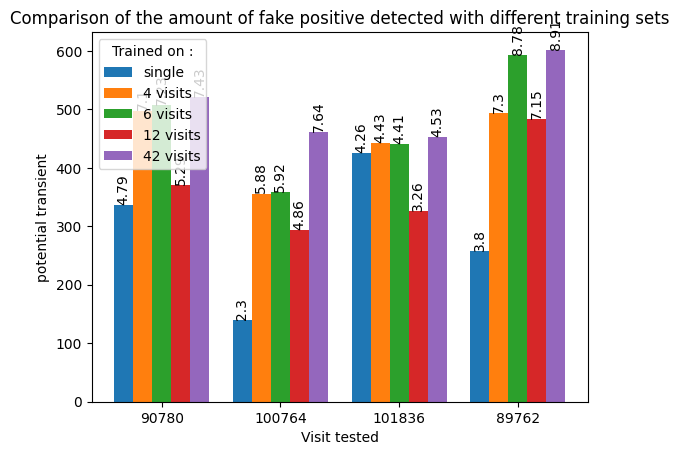

In [14]:

x_labels = ['90780', '100764', '101836', '89762']
# Bar width
width = 0.16

x = np.arange(len(x_labels))
# Create the bar plots
fig, ax = plt.subplots()
ax.bar(x-2*width, nbr_real_transcient, width, label='single')
ax.bar(x-1*width, trained_on4[0], width, label='4 visits')
ax.bar(x , trained_on6[0], width, label='6 visits')
ax.bar(x+1*width, trained_on12[0], width, label='12 visits')
ax.bar(x+2*width, trained_on42[0], width, label='42 visits')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel('Visit tested')
ax.set_ylabel('potential transient')
ax.set_title('Comparison of the amount of fake positive detected with different training sets')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(title = 'Trained on :')

# Add annotations inside the bars
for i, v in enumerate(nbr_real_transcient):
    ax.text(i - 2*width, v + 0.5, str(round(rate_fakes[i]*100,2)), ha='center', rotation='vertical', va='bottom')
    ax.text(i - 1*width, trained_on4[0][i] + 0.5, str(round(trained_on4[1][i]*100,2)), ha='center', rotation='vertical',va='bottom')
    ax.text(i , trained_on6[0][i] + 0.5, str(round(trained_on6[1][i]*100,2)), ha='center', rotation='vertical', va='bottom')
    ax.text(i + 1*width, trained_on12[0][i] + 0.5, str(round(trained_on12[1][i]*100,2)), ha='center', rotation='vertical', va='bottom')
    ax.text(i + 2*width, trained_on42[0][i] + 0.5, str(round(trained_on42[1][i]*100,2)), ha='center', rotation='vertical', va='bottom')

    # Display the plot
plt.show()

## Potential transient rate

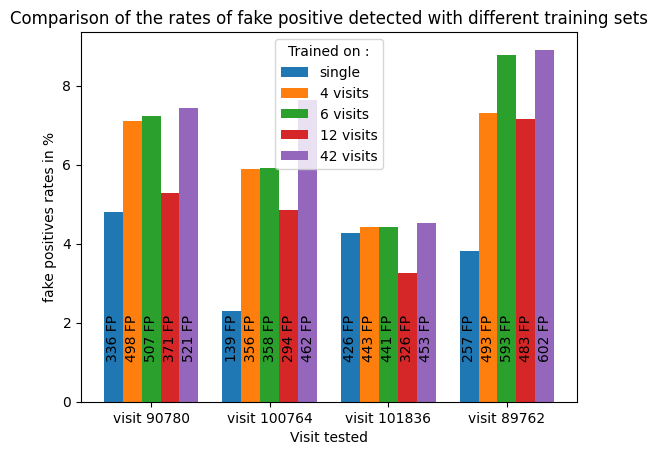

In [15]:

x_labels = ['visit 90780', 'visit 100764', 'visit 101836', 'visit 89762']
# Bar width
width = 0.16

x = np.arange(len(x_labels))
# Create the bar plots
fig, ax = plt.subplots()
ax.bar(x-2*width, [a*100 for a in rate_fakes] , width, label='single')
ax.bar(x-1*width, [a*100 for a in trained_on4[1]], width, label='4 visits')
ax.bar(x, [a*100 for a in trained_on6[1]], width, label='6 visits')
ax.bar(x+1*width, [a*100 for a in trained_on12[1]], width, label='12 visits')
ax.bar(x+2*width, [a*100 for a in trained_on42[1]], width, label='42 visits')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel('Visit tested')
ax.set_ylabel('fake positives rates in %')
ax.set_title('Comparison of the rates of fake positive detected with different training sets')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(title = 'Trained on :')

# Add annotations inside the bars
for i, v in enumerate(nbr_real_transcient):
    ax.text(i - 2*width,  1, f'{str(v)} FP', ha='center', rotation='vertical', va='bottom')
    ax.text(i - 1*width, 1, f'{str(trained_on4[0][i])} FP', ha='center', rotation='vertical',va='bottom')
    ax.text(i, 1,f'{str(trained_on6[0][i])} FP', ha='center', rotation='vertical', va='bottom')
    ax.text(i + 1*width, 1, f'{str(trained_on12[0][i])} FP', ha='center', rotation='vertical', va='bottom')
    ax.text(i + 2*width, 1, f'{str(trained_on42[0][i])} FP', ha='center', rotation='vertical', va='bottom')

    # Display the plot
plt.show()

In [16]:
real_object  = []

for i in range (len(visits_tested)):
    real_object.append(trained_on4[0][i]/trained_on4[1][i])
    

In [17]:
real_object

[7013.0, 6050.0, 9997.0, 6756.0]

# Potential transient correlation regarding the model 

In [18]:
from sklearn.metrics import cohen_kappa_score


## Produce the index lists 

In [19]:
# test again but return the list of fake positives (could b improved implementing it in the fake_positives function

def index_fake(test_size, df_test, x_test, y_test, model, path=None):
    '''
    Produces a table containing the prediction made by the model for each image
    Also calculates the number of errors and the detection efficiency of the model
        
    test_size : Percentage of data that is used
    df_test : dataframe containing the various information associated with the images, in particular the image label
    x_test : matrix containing test data
    y_test : array containing the test labels associated with the test data
    model : model used to make the prediction
    path : path to model
        
    return :
        
    df_test = dataframe containing the information associated with the images as well as the predictions made by the model
        
    '''

    #new label for bogus/transcients
    df_test['bogus_transient']=['bogus'if (a==0) else 'transient' for a in df_test['y_test']]
    print('Taille des données de test :', x_test.shape)
    
    #loading model
    if path is not None:
        load_model = tf.keras.models.load_model(f'{path}/{model}.h5')
        
    else:
        load_model = tf.keras.models.load_model(f'{rundir}models/{model}.h5')
        
    score = load_model.evaluate(x_test, y_test, verbose=0, batch_size=None, steps=None)

    print(f'Test loss     : {score[0]:4.4f}')
    print(f'Test accuracy : {score[1]:4.4f}')

    #model prediction 
    
    y_sigmoid = load_model.predict(x_test) #probability table y_sigmoid[:,0] = prob bogus y_sigmoid[:,1] = prob transcient 
    #Probability of the model belonging to transcient class
    df_test[f'proba_transient_{model}'] = y_sigmoid[:,1]
    df_test[f'proba_transient_perc_{model}'] = (y_sigmoid[:,1]*100).astype(int)

    #Probability of the model belonging to bogus class
    df_test[f'proba_bogus_{model}'] = y_sigmoid[:,0]
    df_test[f'proba_bogus_perc_{model}'] = (y_sigmoid[:,0]*100).astype(int)


    df_test[f'y_pred_{model}'] = np.argmax(y_sigmoid, axis=-1) #Retrieve the class it belongs to

    df_test[f'bogus_transient_pred_{model}']=['bogus' if (a==0) else 'transient' for a in df_test[f'y_pred_{model}']]
    
    
    fakepositive = df_test[(df_test[f'y_pred_{model}'] == 1) & (df_test['y_test'] == 0)]
    real_object = df_test[f'y_pred_{model}'].loc[(df_test.y_test==0)]
    fake_rate = len(fakepositive)/ len(real_object)
    
    #Calcul du nombre d'erreur
    error_bogus=df_test[f'y_pred_{model}'].loc[ (df_test[f'y_pred_{model}']==1) & (df_test.y_test==0)].index.to_list() 
    error_transient=df_test[f'y_pred_{model}'].loc[ (df_test[f'y_pred_{model}']==0) & (df_test.y_test==1)].index.to_list() 
    print('potential real transcient',len(error_bogus))
    
    err =  len(error_bogus)+len(error_transient) #calcul du nombre d'erreur
    eff = (len(x_test)-err)/len(x_test) #calcul de l'efficacité de detection
    
    print(f'Test efficacité : {eff:4.4f}')
    

    return error_bogus

In [20]:
# producing the index for single visit 

arr_index = []

for visit in visits_tested: 
    df_test = globals()[f'df_test_{visit}']
    x_test = globals()[f'x_test_{visit}']
    y_test = globals()[f'y_test_{visit}']
    model = f'model_{visit}'
    index = index_fake(test_size, df_test, x_test, y_test, model, path=models)
    index = [item for item in index if not isinstance(item, str)]

    arr_index.append(index)
  



Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1166
Test accuracy : 0.9586
334/334 [==============================] - 1s 3ms/step
potential real transcient 336
Test efficacité : 0.9586
Taille des données de test : (8580, 30, 30, 1)
Test loss     : 0.0816
Test accuracy : 0.9706
269/269 [==============================] - 1s 4ms/step
potential real transcient 139
Test efficacité : 0.9706
Taille des données de test : (16075, 30, 30, 1)
Test loss     : 0.2129
Test accuracy : 0.9088
503/503 [==============================] - 1s 3ms/step
potential real transcient 426
Test efficacité : 0.9088
Taille des données de test : (8356, 30, 30, 1)
Test loss     : 0.1111
Test accuracy : 0.9591
262/262 [==============================] - 1s 3ms/step
potential real transcient 257
Test efficacité : 0.9591


In [21]:
#producing the index for the trained on several visit
def index_gen (visit_tested, model): 
    arr_index = []
    for visit in visits_tested: 
        df_test = globals()[f'df_test_{visit}']
        x_test = globals()[f'x_test_{visit}']
        y_test = globals()[f'y_test_{visit}']
        index = index_fake(test_size, df_test, x_test, y_test, model, path=models)
        index = [item for item in index if not isinstance(item, str)]
        arr_index.append(index)
        
    return arr_index


In [22]:
visits_tested = [90780, 100764, 101836, 89762]

index_on4 = index_gen(visits_tested, 'model_4_visit')
index_on6 = index_gen(visits_tested, 'model_6_visit')
index_on12 = index_gen(visits_tested, 'model_12_visit')
index_on42 = index_gen(visits_tested, 'model_42_visit')

Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1444
Test accuracy : 0.9444
334/334 [==============================] - 1s 2ms/step
potential real transcient 498
Test efficacité : 0.9444
Taille des données de test : (8580, 30, 30, 1)
Test loss     : 0.1487
Test accuracy : 0.9435
269/269 [==============================] - 1s 2ms/step
potential real transcient 356
Test efficacité : 0.9435
Taille des données de test : (16075, 30, 30, 1)
Test loss     : 0.1101
Test accuracy : 0.9594
503/503 [==============================] - 1s 2ms/step
potential real transcient 443
Test efficacité : 0.9594
Taille des données de test : (8356, 30, 30, 1)
Test loss     : 0.1640
Test accuracy : 0.9356
262/262 [==============================] - 1s 2ms/step
potential real transcient 493
Test efficacité : 0.9356
Taille des données de test : (10680, 30, 30, 1)
Test loss     : 0.1569
Test accuracy : 0.9411
334/334 [==============================] - 1s 2ms/step
potential real transcient 507
Test ef

## Upset plot


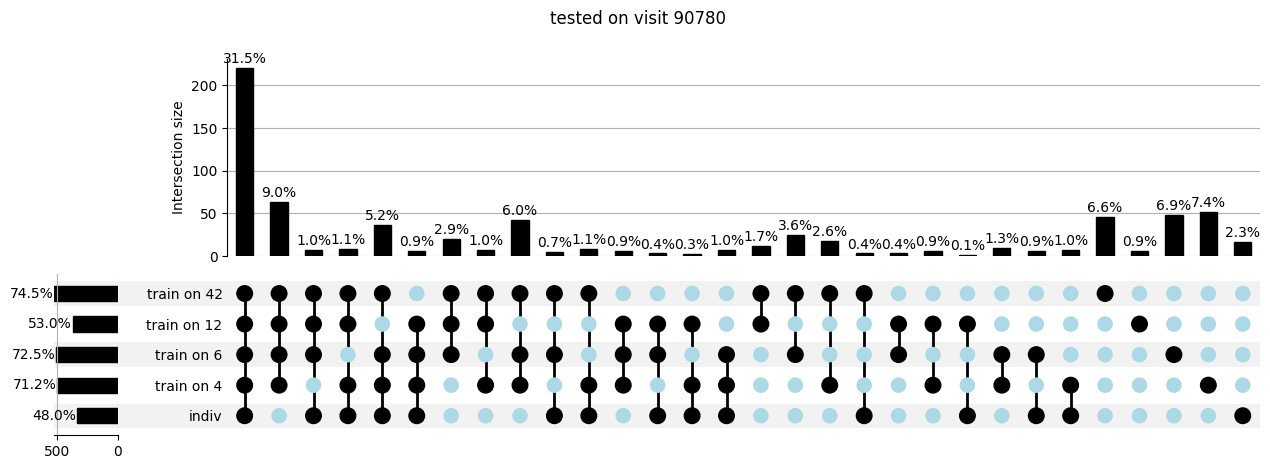

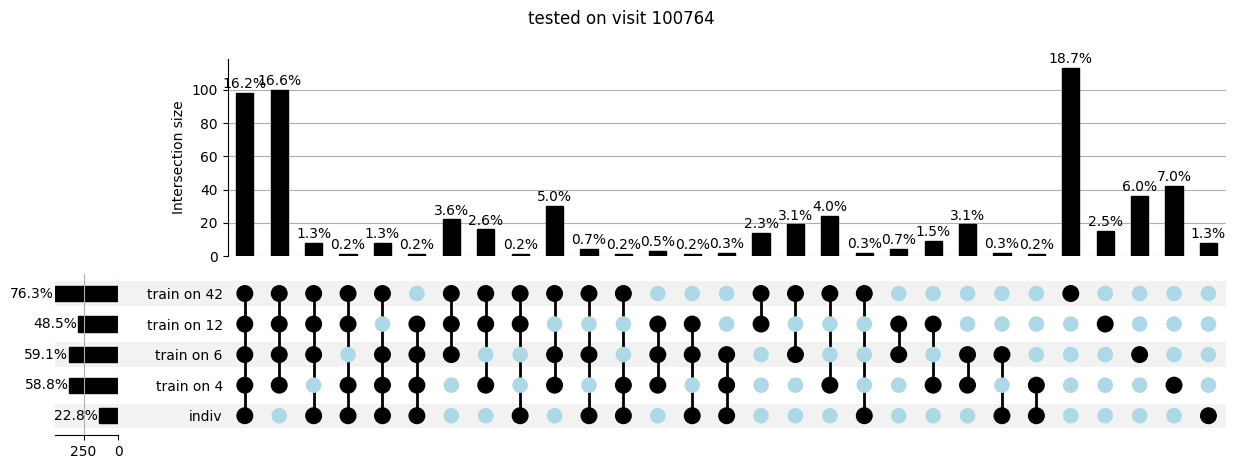

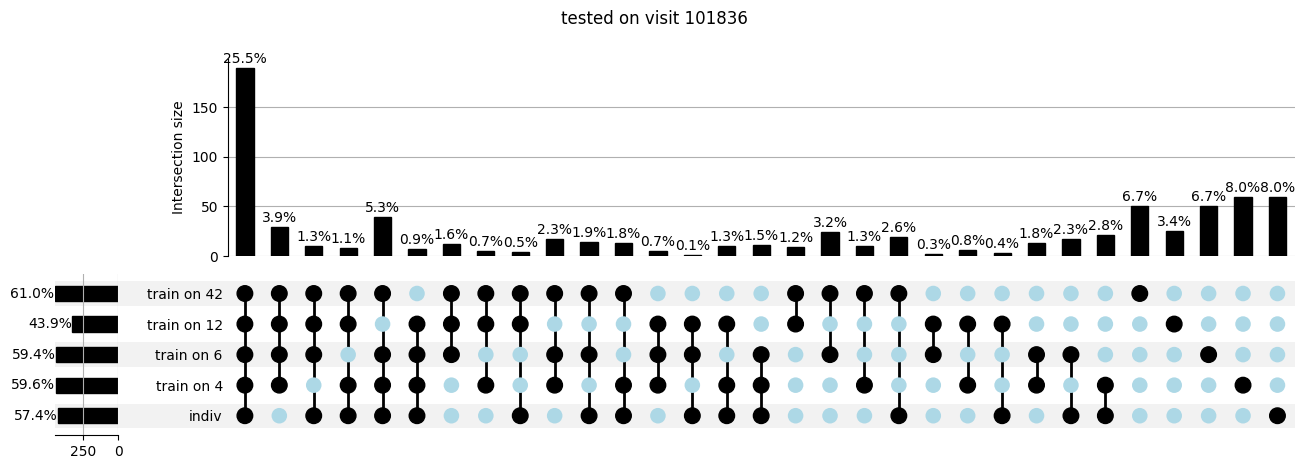

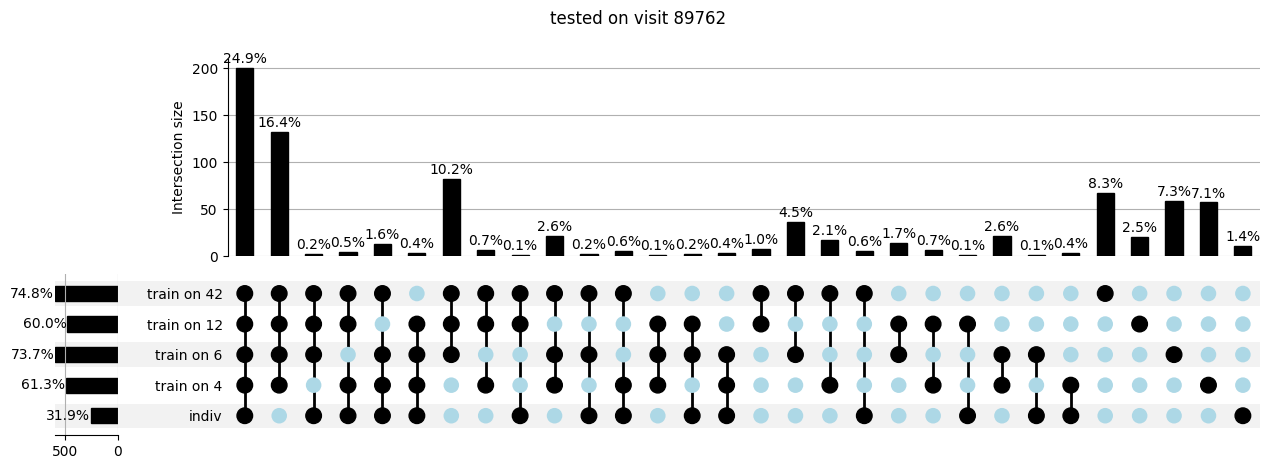

In [23]:
sets = [] 
x_labels = ['visit 90780', 'visit 100764', 'visit 101836', 'visit 89762']

for i in range(4) :
    fig = plt.figure()

    a= { 
    'indiv': set(arr_index[i]),
    'train on 4': set(index_on4[i]),
    'train on 6': set((index_on6[i])),
    'train on 12': set((index_on12[i])),
    'train on 42': set((index_on42[i]))
    }
    sets.append(a)
    plot(from_contents(sets[i]), fig = fig, sort_by = '-degree', sort_categories_by = 'input', other_dots_color = 'lightblue', show_percentages =  True)
    plt.suptitle(f'tested on {x_labels[i]}')
    plt.show()
    

In [24]:
# Observe features correlation ? look at the spies features ?

## Venn diagram

In [25]:
sets = [None] * 4
for i in range(4) : 
    sets[i] =  { 
    'indiv': set(arr_index[i]),
    'train on 4': set(index_on4[i]),
    'train on 6': set((index_on6[i])),
    'train on 12': set((index_on12[i]))
    }


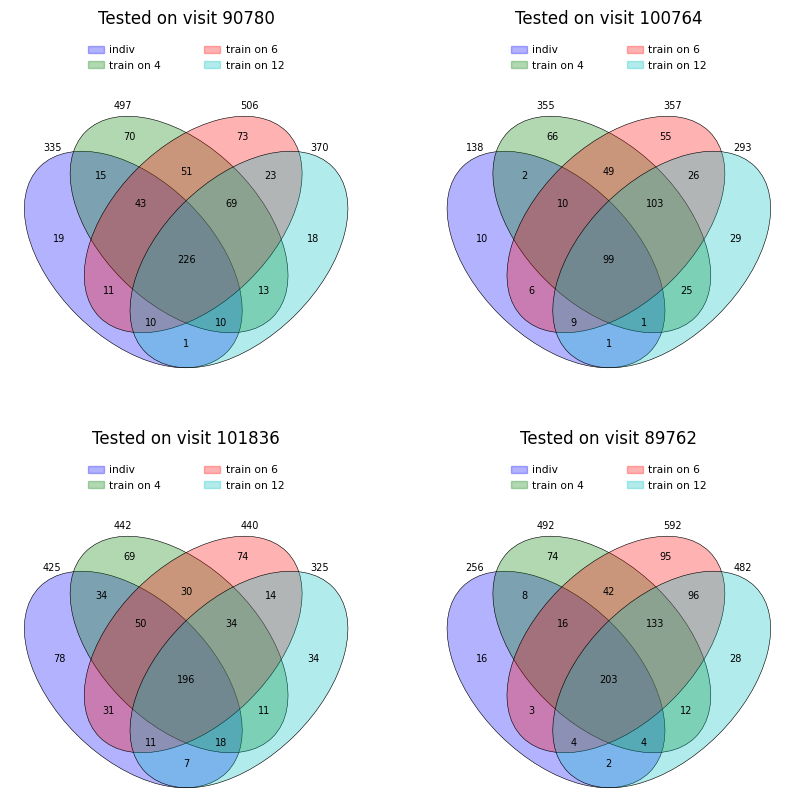

In [ ]:
x_labels = ['visit 90780', 'visit 100764', 'visit 101836', 'visit 89762']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1 = axes[0][0]
venny4py(sets[0], asax=ax1)
ax2 = axes[0][1]
venny4py(sets[1], asax=ax2) 
ax3 = axes[1][0]
venny4py(sets[2], asax=ax3) 
ax4 = axes[1][1]
venny4py(sets[3], asax=ax4)

ax1.title.set_text(f'Tested on {x_labels[0]}')
ax2.title.set_text(f'Tested on {x_labels[1]}')
ax3.title.set_text(f'Tested on {x_labels[2]}')
ax4.title.set_text(f'Tested on {x_labels[3]}')
plt.show()

In [ ]:
#Unique object identified as transcient
    #create a list with the total amount of transcient identified at least by one model as a transcient but removing all the duplicates
unique_single = []

for i in range(4) : 
    unique_single.append(list(set(arr_index[i]+index_on4[i]+index_on6[i]+index_on12[i])))


    print(len(unique_single[i]))

## Identified several times

In [28]:
visits_tested = [90780, 100764, 101836, 89762]
at_least3 = []
for i in range(len(visits_tested)): 
    combined_list = arr_index[i]+index_on4[i]+ index_on6[i]+ index_on12[i]+ index_on42[i]
    
    element_counts = Counter(combined_list)

    # Find elements that are in at least 3 lists
    elements_in_at_least_3_lists = [element for element, count in element_counts.items() if count >= 3]

    at_least3.append(elements_in_at_least_3_lists)
    


In [29]:
len(at_least3[3])

477

# SNR study

In [27]:
#error_bogus=df_test[f'y_pred_{model}'].loc[ (df_test[f'y_pred_{model}']==1) & (df_test.y_test==0)].index.to_list() 


def explore_SNR(tested_set, title, index, apflux): 
    legend = []
    for snr_type in apflux:
        legend.append(snr_type)
        
        SNR_errorbogus = tested_set.loc[index, snr_type]
        clean_fake_pos = tested_set.loc[index]
        clean_fake_pos = clean_fake_pos.loc[(abs(tested_set[snr_type]) > 5)]
        

        SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
        plt.hist(SNR_errorbogus, bins=100)
        plt.xlim([-50, 50])
        plt.axvline(3, color = 'red')
    plt.legend(legend)
    plt.title(f'{title}')
    plt.show()
    return clean_fake_pos

## tests

### Tests

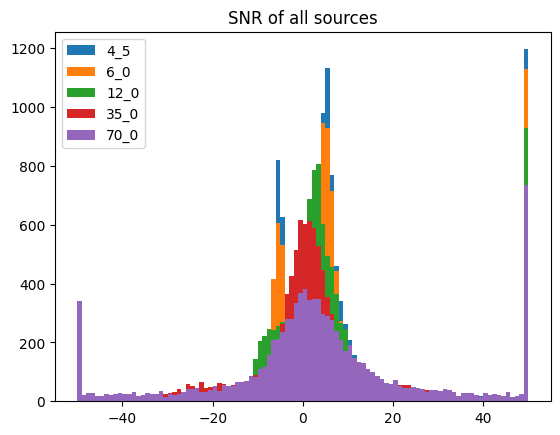

In [31]:
SNR = df_test_90780['SNR_base_CircularApertureFlux_4_5']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
SNR = df_test_90780['SNR_base_CircularApertureFlux_6_0']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
SNR = df_test_90780['SNR_base_CircularApertureFlux_12_0']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
SNR = df_test_90780['SNR_base_CircularApertureFlux_35_0']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
SNR = df_test_90780['SNR_base_CircularApertureFlux_70_0']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
plt.legend(['4_5','6_0','12_0','35_0','70_0' ])
plt.title('SNR of all sources')
plt.show()

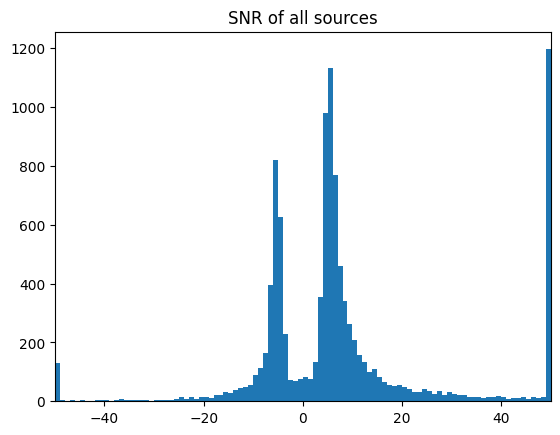

In [32]:
SNR = df_test_90780['SNR_base_CircularApertureFlux_4_5']
SNR = SNR.clip(lower=-50, upper=50)
plt.hist(SNR, bins=100)
plt.xlim([-50, 50])
plt.title('SNR of all sources')
plt.show()

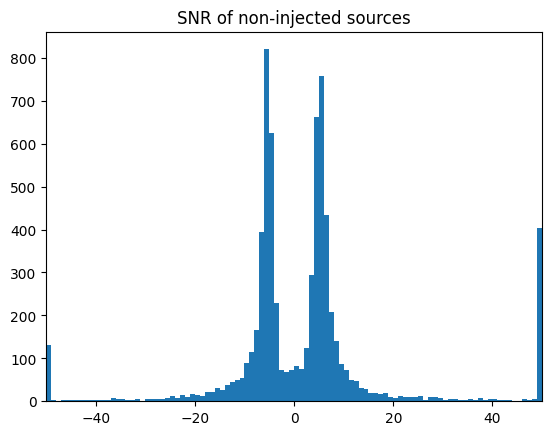

In [33]:
list_real = df_test_90780.loc[(df_test_90780.y_test==0)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_4_5']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of non-injected sources')
plt.xlim([-50, 50])
plt.show()

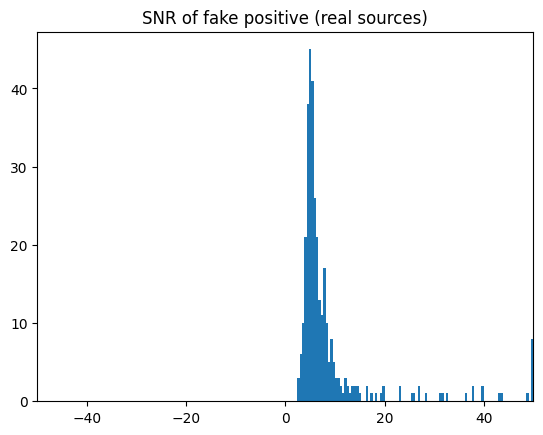

In [34]:
SNR_errorbogus = df_test_90780.loc[arr_index[0], 'SNR_base_CircularApertureFlux_4_5']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.xlim([-50, 50])
plt.title('SNR of fake positive (real sources)')
plt.show()

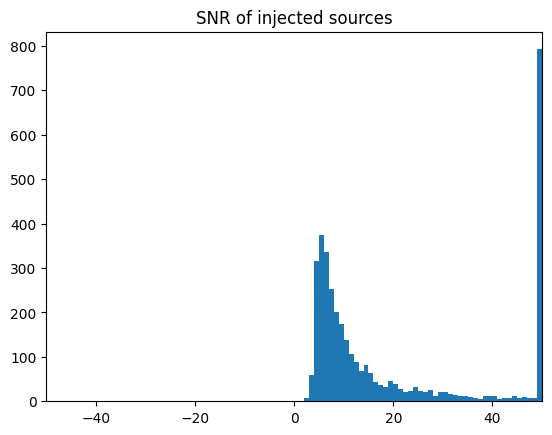

In [35]:
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_4_5']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
plt.show()

(-50.0, 50.0)

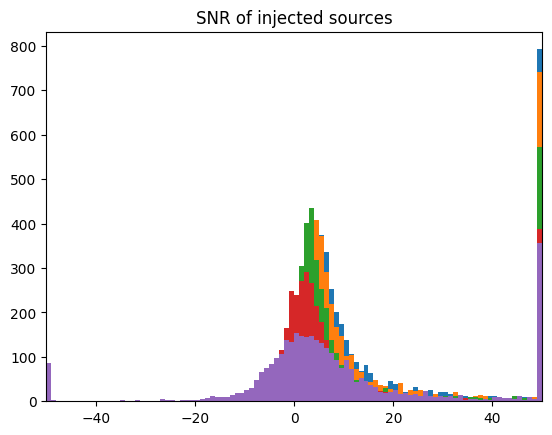

In [36]:
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_4_5']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_6_0']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_12_0']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_35_0']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
list_real = df_test_90780.loc[(df_test_90780.y_test==1)].index.to_list() 
#print(list_real)
SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_70_0']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])

In [ ]:
df_proba_90780 = df_proba(test_size, df_test_90780, x_test_90780, y_test_90780, 'model_4_visit')


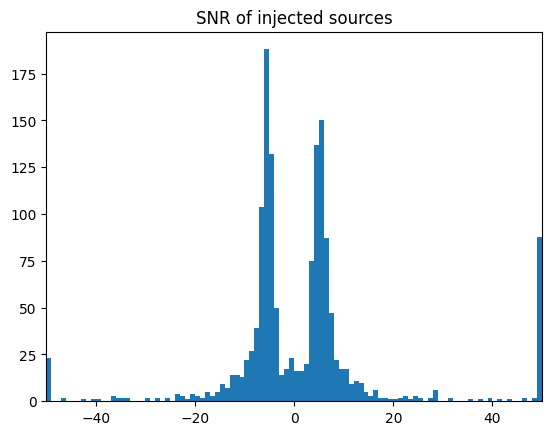

1523


In [23]:
list_real = df_proba_90780.loc[(df_test_90780.y_test==0)&(df_proba_93404['proba_transient_perc_model_4_visit']>90)].index.to_list() 

SNR_errorbogus = df_test_90780.loc[list_real, 'SNR_base_CircularApertureFlux_4_5']
SNR_errorbogus = SNR_errorbogus.clip(lower=-50, upper=50)
plt.hist(SNR_errorbogus, bins=100)
plt.title('SNR of injected sources')
plt.xlim([-50, 50])
plt.show()
print(len(list_real))

## analysis


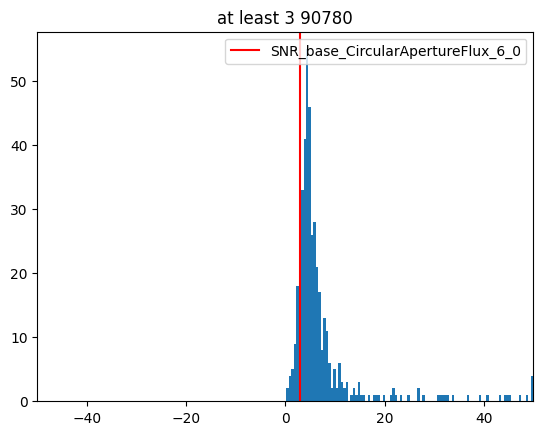

In [37]:
clean_FP_90780 = explore_SNR(df_test_90780,'at least 3 90780', at_least3[0],['SNR_base_CircularApertureFlux_6_0'])

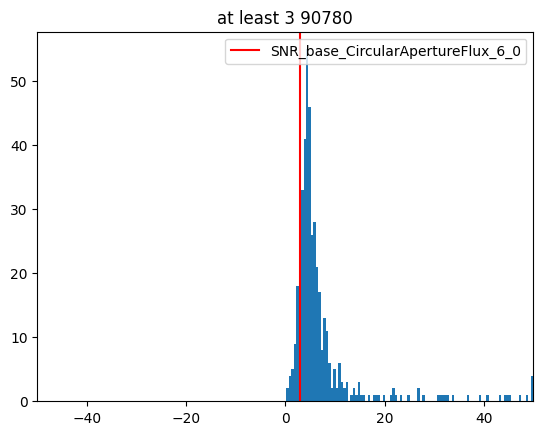

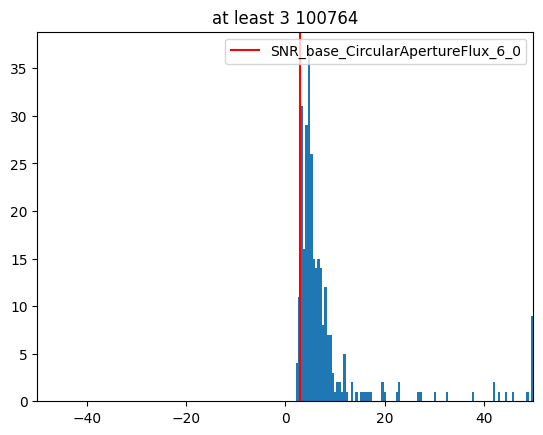

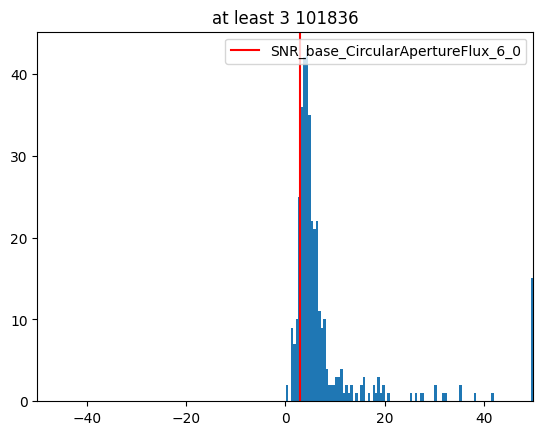

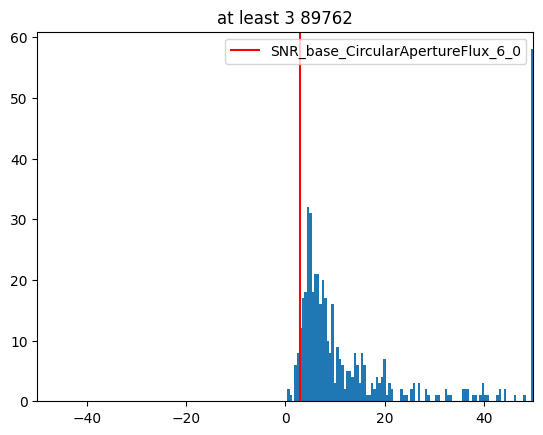

In [38]:
visits_tested = [90780, 100764, 101836, 89762]
clean_FP = []
for i,visit in enumerate(visits_tested): 
    df_test = globals()[f'df_test_{visit}']
    clean = explore_SNR(df_test,f'at least 3 {visit}', at_least3[i],['SNR_base_CircularApertureFlux_6_0'])
    clean_FP.append(clean)

# Light curve 

In [4]:
df_proba_93404 = df_proba(test_size, df_test_93404, x_test_93404, y_test_93404, 'model_4_visit')

Taille des données de test : (12133, 30, 30, 1)
Test accuracy : 0.9169
380/380 [==============================] - 1s 2ms/step
potential real transcient 797
Test efficacité : 0.9169


In [7]:
df_proba_93404['y_test']

0                      0
1                      1
2                      1
3                      0
4                      1
                      ..
Negative               0
Interpolation          0
Simulated transient    1
Transient              1
Low signal to noise    0
Name: y_test, Length: 12133, dtype: int64

In [5]:
df_proba_93404['proba_transient_perc_model_4_visit']

0                       2
1                      98
2                      88
3                       0
4                      96
                       ..
Negative                0
Interpolation           2
Simulated transient    98
Transient              89
Low signal to noise    70
Name: proba_transient_perc_model_4_visit, Length: 12133, dtype: int64

In [8]:
df_proba_93404['y_pred_model_4_visit']

0                      0
1                      1
2                      1
3                      0
4                      1
                      ..
Negative               0
Interpolation          0
Simulated transient    1
Transient              1
Low signal to noise    1
Name: y_pred_model_4_visit, Length: 12133, dtype: int64

(array([6423.,  351.,  240.,  202.,  181.,  228.,  279.,  441.,  935.,
        2853.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

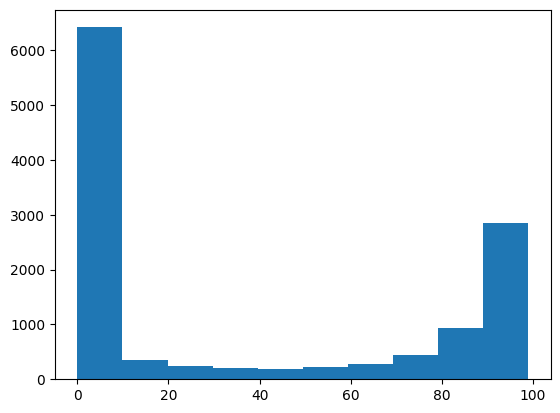

In [24]:
plt.hist(df_proba_93404['proba_transient_perc_model_4_visit'])

In [ ]:
idx_transient = df_test[f'proba_transient_{model}'].loc[df_test['y_test'] == 1]
bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

counts_t, bins_t = np.histogram(df_test[f'proba_transient_{model}'], bins=bins)
counts_1, bins_1 = np.histogram(idx_transient, bins=bins)

plt.bar(bins[:-1], height=counts_t, width=0.08, align = 'edge')
plt.bar(bins[:-1], height=counts_1, width=0.08, align = 'edge')
plt.xlabel('Model output : y')
plt.ylabel('Count')
plt.savefig(imagedir+'Distribution_transient.png', bbox_inches='tight')
plt.show()